# Benchmark for vibration of a string

Assumptions made:
- string is treated as perfectly flexible (no stiffness)
- fixed-fixed condition so that reflections are perfectly inverted

Goal: simulate the kink resulting from plucking the string

Constituitive equation (wave equation): $\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}$

where,
$
y = displacement\:of\:the\:string\:from\:equilibirum \\
x = position\:along\:the\:string \\
t = time \\
c = \sqrt{\frac{T}{\mu}} = wave\:speed \\
T = tension \\
\mu = mass\:per\:unit\:length \\
$

Citation(s):
$@article\:{giordano1998physics,
  title={The physics of vibrating strings},
  author={Giordano, Nicholas and Gould, Harvey and Tobochnik, Jan}, 
  journal={Computers in Physics}, 
  volume={12},
  number={2}, 
  pages={138--145}, 
  year={1998},
  publisher={American Institute of Physics}
}$

In [51]:
using CombinatorialSpaces
using Catlab.CategoricalAlgebra
using CombinatorialSpaces.DiscreteExteriorCalculus: inv_hodge_star
using DifferentialEquations
using Catlab.Graphs
using Catlab.Graphics
using Plots

# dual subdivision 
function dual(s::EmbeddedDeltaSet1D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex1D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh and boundary conditions

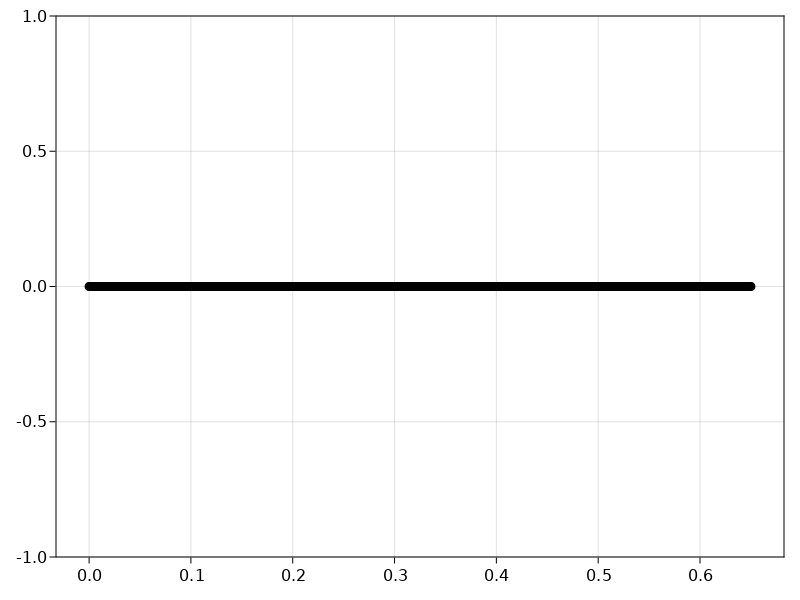

In [59]:
# Define mesh
s2D = EmbeddedDeltaSet2D("meshes/string.obj")
s = EmbeddedDeltaSet1D{Bool, eltype(s2D[:point])}()
# copy_parts!(s, s2D)

add_vertices!(s, 650, point=[eltype(s2D[:point])(i,0.0,0.0) for i in range(0, 0.65, length=650)])
add_edges!(s, [i for i in 1:(nv(s)-1)], [i+1 for i in 1:(nv(s)-1)], edge_orientation=true)

sd = dual(s)

# Define vertices for BC application (fixed-fixed)
left = 1
right = nv(s)

# Plot mesh
x_loc = [p[1] for p in s[:point]]
y_loc = [p[2] for p in s[:point]]
plot(x_loc, y_loc,
     legend=:none, seriestype = :scatter,
     xlabel="x-coordinate",ylabel="y-coordinate",
     title="Initial String System",
     ylims=[minimum(y_loc),maximum(y_loc)],
     xlims=[minimum(x_loc),maximum(x_loc)], ratio=1)

## Add the physics

In [66]:
c = 200 # wave speed, m/s
γ = -0.25 # damping, N*s/m

# Define primal forms
x = VForm([p[1] for p in s[:point]]); # x-location along string
y = VForm([p[2] for p in s[:point]]); # y-location 
y.data[200] = 1e-3 # pluck point
v = VForm(zeros(nv(s))) # y velocity


lapl = ∇²(Val{0}, sd) # initialize the laplacian operator

u0 = vcat(x.data, y.data, v.data) # initial condition for displacement

x_range = 1:length(x)
y_range = (1:length(y)) .+ length(x)
v_range = (1:length(v)) .+ length(x) .+ length(y)

# Physics WITHOUT damping
vf1(du, u, p, t) = begin
    du[v_range] .= (-1 * p[1]) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[left] = 0.0
    du[right] = 0.0
end

# Physics WITH damping
vf2(du, u, p, t) = begin
    du[v_range] .= (-1 * p[1]) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[v_range] .= u[v_range] * p[2] # updates acceleration with some damping
    du[left] = 0.0
    du[right] = 0.0
end

vf (generic function with 1 method)

## Run the simulation(s)

In [67]:
# WITHOUT damping
tspan = (0.0,10.0)
prob = ODEProblem(vf, u0, tspan, [c])
sol = solve(prob);

# WITH damping
tspan = (0.0,10.0)
prob = ODEProblem(vf, u0, tspan, [c])
sol = solve(prob);

## Plot results

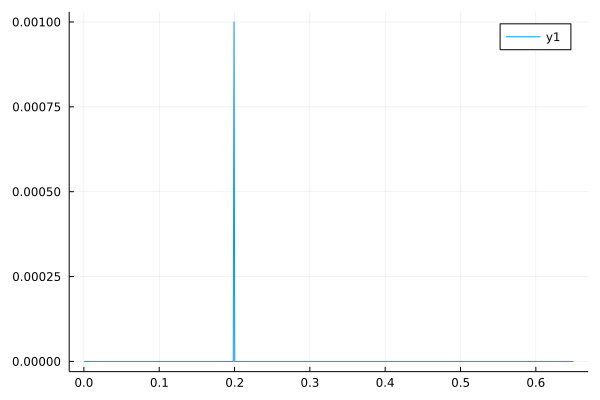

In [68]:
# Plot mesh @ t = 1e-3 seconds
x_loc = [p[1] for p in s[:point]]
y_loc = sol(1e-3)[y_range]
Plots.plot(x_loc, y_loc, label = 'free vibration")